In [134]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

In [135]:
def spiraldata(N=150):
    r = np.linspace(1,2*np.pi,N)
    X1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    X2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    X = np.concatenate([X1, X2], axis=0)
    X +=  np.random.randn(X.shape[0], X.shape[1])*0.5
    y = np.concatenate([np.ones(N), -1 * np.ones(N)]) 
    return X,y

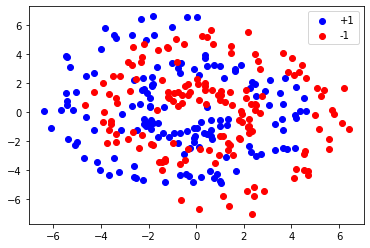

In [136]:
X,y=spiraldata()
fig = plt.figure()
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b')
plt.scatter(X[y != 1, 0], X[y != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [138]:
def visclassifier(fun,X,y,w=[],b=0):
    y = np.array(y).flatten()
    w = np.array(w).flatten()
    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(y)
    plt.figure()
    res=200
    xrange = np.linspace(min(X[:, 0]), max(X[:, 0]),res)
    yrange = np.linspace(min(X[:, 1]), max(X[:, 1]),res)
    pixelX = np.matlib.repmat(xrange, res, 1)
    pixelY = np.matlib.repmat(yrange, res, 1).T
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
    testpreds = fun(xTe)
    Z = testpreds.reshape(res, res)

    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(X[y == c,0],
            X[y == c,1],
            marker=marker_symbols[idx],
            color='k'
           )
    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    plt.show()

In [139]:
def kernel(X,Z,sigma=1):
    if X.ndim!=1 and X.shape[1]!=1:
        D=np.array([[np.linalg.norm(i-j) for j in Z] for i in X])
    else:   
        D=np.linalg.norm(X-Z)
    K=np.exp(-(D**2)/(sigma**2))
    return K

In [140]:
def SMO(X,y,C,tol,max_passes):
    alpha=np.zeros(len(y),)
    bias=0
    passes=0
    alpha_total=[]
    alpha_distance_total=[]
    iters=0
    while passes<max_passes:
        num_changed_alphas=0
        alpha_old=alpha.copy()
        for i in range(len(y)):
            E_i=0
            kii=kernel(X[i],X[i])
            for k in range(len(y)):
                E_i+=alpha[k]*y[k]*kernel(X[i],X[k])
            E_i=E_i+bias-y[i]
            condi=y[i]*E_i
            if (condi<(-tol) and alpha[i]<C) or (condi>tol and alpha[i]>0): 
                while True:
                    j=int(np.random.choice(len(y),1))
                    if j!=i:
                        break

                kij=kernel(X[i],X[j])
                kjj=kernel(X[j],X[j])
                E_j=0
                for k in range(len(y)):
                    E_j+=alpha[k]*y[k]*kernel(X[j],X[k])
                E_j=E_j+bias-y[j]
                   
                alpha_i_old=alpha[i]
                alpha_j_old=alpha[j]
                if y[i]!=y[j]:
                    L=max(0,alpha[j]-alpha[i])
                    H=min(C,C+alpha[j]-alpha[i])
                else:
                    L=max(0,alpha[i]+alpha[j]-C)
                    H=min(C,alpha[i]+alpha[j])
                if L==H:
                    continue
                eta=2*kij-kii-kjj
                if eta>=0:
                    continue
                alpha[j]-=(y[j]*(E_i-E_j)/eta)
                if alpha[j]>H:
                    alpha[j]=H
                if alpha[j]<L:
                    alpha[j]=L
                if abs(alpha[j]-alpha_j_old)<1e-5:
                    continue
                alpha[i]+=y[i]*y[j]*(alpha_j_old-alpha[j])
                i_=y[i]*(alpha[i]-alpha_i_old)
                j_=y[j]*(alpha[j]-alpha_j_old)
                
                if alpha[i]>0 and alpha[i]<C:
                    bias=bias-E_i-i_*kii-j_*kii
                elif alpha[j]>0 and alpha[j]<C:
                    bias=bias-E_j-i_*kij-j_*kjj
                else:
                    bias=(2*bias-E_i-i_*(kii+kij)-j_*(kii+kjj)-E_j)/2
                num_changed_alphas+=1
        if num_changed_alphas==0:
            passes+=1
        else:
            passes=0

        alpha_total.append(alpha.copy())
        alpha_distance_total.append(np.linalg.norm(alpha-alpha_old))
        iters+=1

    return alpha,bias,iters,alpha_total,alpha_distance_total

In [141]:
tol=1e-3
max_passes=3
C=2
start_time_SMO=time.time()
alpha_SMO,bias_SMO,iters_SMO,alpha_total_SMO,alpha_distance_total_SMO=SMO(X,y,C,tol,max_passes)
time_SMO=(time.time()-start_time_SMO)/iters_SMO
print("each iteration of SMO costs %f seconds" %time_SMO)

each iteration of SMO costs 0.888084 seconds


In [142]:
svmclassify_SMO=lambda x:(alpha_SMO*y)@kernel(X,x)+bias_SMO

In [143]:
training_error=np.mean(np.sign(svmclassify_SMO(X))!=y)
print("Training error: %2.4f" % training_error)

Training error: 0.0467


<ipython-input-138-1131bb472e75>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if w != []:


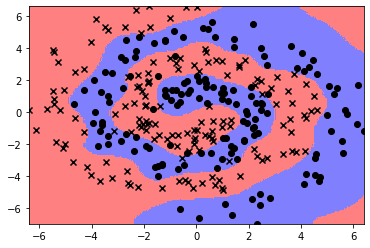

In [144]:
visclassifier(svmclassify_SMO,X,y)

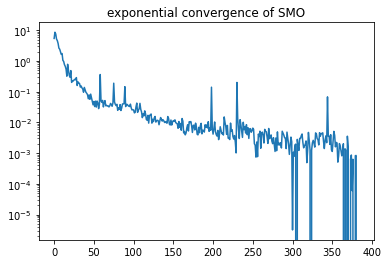

In [145]:
plt.semilogy(alpha_distance_total_SMO)
plt.title("exponential convergence of SMO")
plt.show()

<ipython-input-163-9cf0be057621>:3: RuntimeWarning: invalid value encountered in double_scalars
  conv1.append(np.linalg.norm(alpha_total_SMO[i+1]-alpha_SMO)/np.linalg.norm(alpha_total_SMO[i]-alpha_SMO))


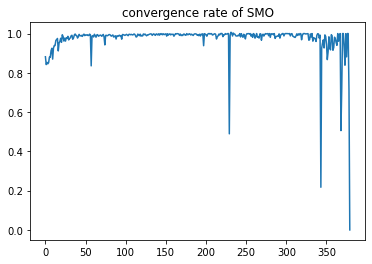

In [163]:
conv1=[]
for i in range(iters_SMO-1):
    conv1.append(np.linalg.norm(alpha_total_SMO[i+2]-alpha_SMO)/np.linalg.norm(alpha_total_SMO[i]-alpha_SMO))
plt.plot(conv1)
plt.title('convergence rate of SMO')
plt.show()

In [170]:
max(conv1)

0.984114980019872

In [147]:
def log(alpha): 
  alpha=(alpha>0)*alpha+(alpha<=0)*0
  return np.log(alpha)

In [148]:
class function:
    def __init__(self,alpha0,t,H,C=2):
        self.alpha = alpha0
        self.t = t
        self.H = H
        self.C = C
        self.ones = np.ones_like(alpha0)
        self.update()

    def update(self):
        self.f = self.func(self.alpha)
        self.df = self.gradient(self.alpha)
        self.d2f = self.hessian(self.alpha)
    
    def func(self,alpha): 
        return self.t*(0.5*alpha.T@self.H@alpha-np.sum(alpha))-np.sum(log(alpha))-np.sum(log(self.C*self.ones-alpha))
    
    def gradient(self,alpha):
        return self.t*self.H@alpha-self.t*self.ones-(np.divide(self.ones,alpha)+np.divide(self.ones,(alpha-self.C*self.ones)))

    def hessian(self,alpha):
        return self.t*self.H+np.diag(np.divide(self.ones,alpha**2))+np.diag(np.divide(self.ones,(alpha-self.C*self.ones)**2))

    def update_alpha(self,alpha):
        self.alpha=alpha
        self.update()
        
    def update_t(self,t):
        self.t=t
        self.update()
        
    def __call__(self,alpha):
        return self.func(alpha)

In [149]:
def ls(f,p,c1,rho):
    alpha=1
    while f(f.alpha+alpha*p)>f.f+(c1*alpha*f.df.T@p):
        alpha=rho*alpha
    return alpha

In [150]:
def newton_step(f,A):    
    m=np.vstack((f.d2f,A))
    m=np.hstack((m, np.vstack((A.T,0))))  
    b=np.hstack((-f.df,0))    
    d_alpha_=np.linalg.inv(m)@b
    d_alpha=d_alpha_[:-1]
    return d_alpha

In [151]:
def descentLinesearch(f):
    A=y.reshape(-1,1).T
    c1=1e-4
    rho=0.5
    tolNW=1e-12
    d_alpha=newton_step(f,A)
    decrement=d_alpha.T@f.d2f@d_alpha
    while decrement/2>tolNW:
        p_k=-np.linalg.inv(f.d2f)@f.df
        if p_k.T@f.df>0: 
            p_k=-p_k
        x_k=ls(f,p_k,c1,rho)
        f.update_alpha(f.alpha+x_k*p_k)         
        d_alpha=newton_step(f,A)
        NWdec=x_k**2*p_k.T@f.d2f@p_k/2
        if NWdec<1e-12:
            break
        decrement=d_alpha.T@f.d2f@d_alpha
        
    return f.alpha

In [152]:
def barrier_interior_point(f,H,m,t,mu,tol):
    iters=0
    bias=0
    alpha_total=[]
    alpha_distance_total=[]
    while m/t>tol:     
        x_k_1=f.alpha
        x_k=descentLinesearch(f)
        alpha_distance_total.append(np.linalg.norm(x_k-x_k_1))
        alpha_total.append(x_k_1)
        t=mu*t
        f.update_alpha(x_k)   
        f.update_t(t)
        iters+=1
        
    alpha=x_k
    b_=np.where(alpha>0)[0]
    for i in b_:
        bias+=y[i]-np.sum(alpha*y*H[:,i])
    bias=bias/b_.shape[0]
    
    return alpha,bias,iters,alpha_total,alpha_distance_total

In [177]:
H=np.zeros((len(y),len(y)))
for i in range(len(y)):
    for j in range(len(y)):
        H[i,j]=y[i]*y[j]*kernel(X[i],X[j])
w0=np.ones_like(y)
w0=w0/100
f=function(w0,H=H,t=1)


In [178]:
m=y.shape[0]
t=1
mu=1.1
tol=1e-8
start_time_B=time.time()
alpha_B,bias_B,iters_B,alpha_total_B,alpha_distance_total_B=barrier_interior_point(f,H,m,t,mu,tol)
time_B=(time.time()-start_time_B)/iters_B
print("each iteration of barrier interior point method costs %f seconds" %time_B)

<ipython-input-147-9f49deee9bde>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha)
each iteration of barrier interior point method costs 0.114327 seconds


In [155]:
svmclassify_B=lambda x:(alpha_B*y)@kernel(X,x)+bias_B

In [156]:
training_error=np.mean(np.sign(svmclassify_B(X))!=y)
print("Training error: %2.4f" % training_error)

Training error: 0.0467


<ipython-input-138-1131bb472e75>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if w != []:


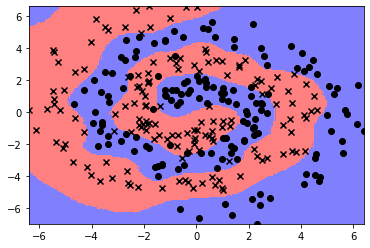

In [157]:
visclassifier(svmclassify_B,X,y)

In [176]:
iters_B

254

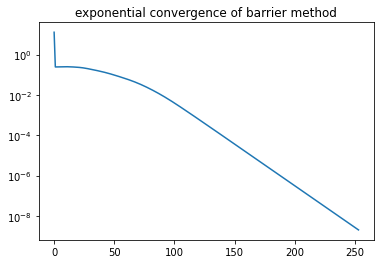

In [171]:
plt.semilogy(alpha_distance_total_B)
plt.title("exponential convergence of barrier method")
plt.show()

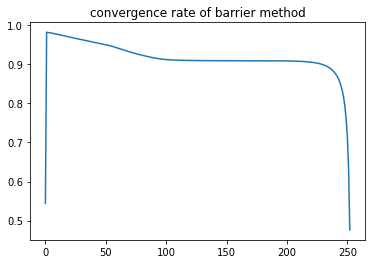

In [172]:
conv2=[]
for i in range(iters_B-1):
    conv2.append(np.linalg.norm(alpha_total_B[i+1]-alpha_B)/np.linalg.norm(alpha_total_B[i]-alpha_B))
plt.plot(conv2)
plt.title('convergence rate of barrier method')
plt.show()